# Hanadi's Capstone Project (Personlized Recipe Recommendation)

In [989]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
import re

import nltk
import string
import ast
import re
import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import config



## Background

Food is the source of energy, having food high in nutritional value is important for the overall health. Being aware of the amount of nutrients in our food help us keep track of meeting our daily needs of energy and nutrients, thus maintaining our health. Time availability to cook varies from time to time, but that shouldn’t prevent us from having the same nutritious meals. For that, I wanted to create a Recommendation system that suggest a recipe based on user’s preference of main ingredient, time to cook, and nutritional information.


## Data

Original dataset contained 35,516 instances & 47 feature. The dataset was scrapped from a recipe website called Allrecipe, and was obtained from this GitHub repo:
https://github.com/shaansubbaiah/allrecipes-scraper/tree/main/export

For this project I will be using 13 features which are:
| Feature         | Description |
|  :---:          |   :---:     |
|  name           | recipe name |
| category        | Recipe category, example (main dish, desserts, bread, ... ect) |
| rating          | Recipe rating |
| rating count    | Number of ratings |
| url             | link to this recipe |
| ingredients     | ingredients used in this recipe |
| total           | total recipe time, preparation and cooking time |
| servings        | number of servings in this recipe |
| yield           | what will this recipe yield, example (3 cups, 12 cupcakes, ... ect) |
| calories        | amount of calories per serving |
| carbohydrates_g | grams of carbohydrate per serving |
| fat_g           | grams of fat per serving |
| protein_g       | grams of protein per serving |


## Data preprocessing

In [990]:
##Read the data
Recipe = pd.read_csv("../data/scraped-07-05-21.csv", index_col=0)

In [991]:
## original dataset shape
Recipe.shape


(35516, 47)

In [992]:
### Check the dataset
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 0 to 35515
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   35516 non-null  object 
 1   url                    35516 non-null  object 
 2   category               35516 non-null  object 
 3   author                 35475 non-null  object 
 4   summary                35516 non-null  object 
 5   rating                 35516 non-null  float64
 6   rating_count           35516 non-null  int64  
 7   review_count           35516 non-null  int64  
 8   ingredients            35516 non-null  object 
 9   directions             35516 non-null  object 
 10  prep                   33390 non-null  object 
 11  cook                   27857 non-null  object 
 12  total                  33564 non-null  object 
 13  servings               35516 non-null  int64  
 14  yield                  35515 non-null  object 
 15  ca

In [993]:
##Check for duplicates
Recipe.duplicated().sum()

0

In [994]:
##Drop the features that I don't need, for example: (author, summary, review_count, directions, sodium_mg, calories_from_fat, & all micronutirents)
Recipe.drop(['author', 'summary', 'review_count', 'directions', 'sugars_g', 'saturated_fat_g', 'cholesterol_mg', 'dietary_fiber_g', 'sodium_mg', 'calories_from_fat', 'prep', 'cook','calcium_mg', 'iron_mg', 'magnesium_mg', 'potassium_mg', 'vitamin_a_iu_IU', 'niacin_equivalents_mg', 'vitamin_c_mg', 'folate_mcg', 'thiamin_mg', 'zinc_mg', 'phosphorus_mg', 'vitamin_b6_mg', 'riboflavin_mg', 'vitamin_e_iu_IU', 'vitamin_k_mcg', 'biotin_mcg' , 'vitamin_b12_mcg', 'mono_fat_g', 'poly_fat_g', 'trans_fatty_acid_g', 'omega_3_fatty_acid_g', 'omega_6_fatty_acid_g'], axis=1, inplace=True )


In [995]:
#Check shape after deleting unnecssary features
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 0 to 35515
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             35516 non-null  object 
 1   url              35516 non-null  object 
 2   category         35516 non-null  object 
 3   rating           35516 non-null  float64
 4   rating_count     35516 non-null  int64  
 5   ingredients      35516 non-null  object 
 6   total            33564 non-null  object 
 7   servings         35516 non-null  int64  
 8   yield            35515 non-null  object 
 9   calories         35402 non-null  float64
 10  carbohydrates_g  35368 non-null  float64
 11  fat_g            35098 non-null  float64
 12  protein_g        35255 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 3.8+ MB


In [996]:
## Look at the head before cleaning
Recipe.head(3)

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g
0,Simple Macaroni and Cheese,https://www.allrecipes.com/recipe/238691/simpl...,main-dish,4.42,834,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,30 mins,4,4 servings,630.2,55.0,33.6,26.5
1,Gourmet Mushroom Risotto,https://www.allrecipes.com/recipe/85389/gourme...,main-dish,4.80,3388,"6 cups chicken broth, divided ; 3 tablespoons ...",50 mins,6,6 servings,430.6,56.6,16.6,11.3
2,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,4.80,1156,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...",20 mins,8,8 crepes,163.8,17.2,7.7,6.4


In [997]:
##checking for missing calue
Recipe.isna().sum()
#Maximum missing values were in total cooking time was (1952) which represents 5% of the total data.
#All other missing values were in the nutrient information features  were less than (500).

name                  0
url                   0
category              0
rating                0
rating_count          0
ingredients           0
total              1952
servings              0
yield                 1
calories            114
carbohydrates_g     148
fat_g               418
protein_g           261
dtype: int64

In [998]:
###Dealing with missing data, I'll drop the instences that doesn't contain the maximum missing values feature represents only 5% of the total data.

Recipe.dropna(inplace=True)
Recipe.isna().sum()


name               0
url                0
category           0
rating             0
rating_count       0
ingredients        0
total              0
servings           0
yield              0
calories           0
carbohydrates_g    0
fat_g              0
protein_g          0
dtype: int64

### Nutrition values columns

In [999]:

##Check the maximum values for nutrition values
Recipe.describe()


,rating,rating_count,servings,calories,carbohydrates_g,fat_g,protein_g
count,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000
mean,4.002661,136.172135,10.090357,318.526714,28.546888,16.734657,14.192982
std,1.372287,521.557650,11.517070,212.192220,24.092086,14.545362,14.063005
min,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000
25%,4.110000,4.000000,4.000000,167.625000,10.800000,6.700000,3.700000
50%,4.480000,21.000000,8.000000,280.000000,24.000000,13.300000,8.800000
75%,4.670000,88.000000,12.000000,421.900000,40.400000,22.900000,22.000000
max,5.000000,19358.000000,832.000000,4709.200000,578.200000,383.900000,273.200000


In [1000]:
##I found crazy large amount of max	serving=832, calories=4709.2, carbs=578.2, fat=383.9, protein=273.2
## So, I decided to put upper limit of calories at 1000 kcal, in which 50% are carbs = 125 g, 25% are fat = 28 g, and 25% are protein =63 g.
## For serving, the upper limit would be the 75th % = 12.

Recipe = Recipe[Recipe['calories'] <= 1000]
Recipe = Recipe[Recipe['fat_g'] <= 28]
Recipe = Recipe[Recipe['protein_g'] <= 63]
Recipe = Recipe[Recipe['carbohydrates_g'] <= 125]
Recipe = Recipe[Recipe['servings'] <= 12]

In [1001]:
##Check the again after setting up maximum limits
Recipe.describe()


,rating,rating_count,servings,calories,carbohydrates_g,fat_g,protein_g
count,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000
mean,4.001043,133.255397,6.792435,277.063584,28.013247,12.604940,13.390392
std,1.359057,530.601374,3.106487,134.686314,20.640242,7.478032,11.464151
min,0.000000,0.000000,1.000000,3.200000,0.000000,0.000000,0.000000
25%,4.100000,4.000000,4.000000,176.175000,11.400000,6.500000,4.300000
50%,4.470000,21.000000,6.000000,266.750000,24.600000,12.000000,9.300000
75%,4.670000,86.000000,8.000000,364.600000,40.300000,18.500000,20.800000
max,5.000000,19358.000000,12.000000,904.000000,123.400000,28.000000,62.800000


### Total (cooking time) column

In [1002]:
###Remove recipe that takes a week or longer to cook.
searchfor = ['week']
Recipe = Recipe[~Recipe.total.str.contains('|'.join(searchfor))]

In [1003]:
## Convert total from string to int
def humantime2minutes(s):
    d = {
      'd':      24*60,
      'day':    24*60,
      'days':   24*60,
      'hr':      60,
      'hrs':     60,
    }
    mult_items = defaultdict(lambda: 1).copy()
    mult_items.update(d)

    parts = re.search(r'^(\d+)([^\d]*)', s.lower().replace(' ', ''))
    if parts:
        return int(parts.group(1)) * mult_items[parts.group(2)] + humantime2minutes(re.sub(r'^(\d+)([^\d]*)', '', s.lower()))
    else:
        return 0
        

In [1004]:
#Apply the function to the column
Recipe['total'] = Recipe['total'].apply(humantime2minutes)


In [1005]:
##Check after cleaning
Recipe.describe()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
count,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000,21668.000000
mean,4.000759,133.297582,97.300166,6.790844,277.128124,28.017367,12.608639,13.394660
std,1.359360,530.742108,231.325450,3.106085,134.667401,20.639325,7.476456,11.465576
min,0.000000,0.000000,1.000000,1.000000,3.200000,0.000000,0.000000,0.000000
25%,4.100000,4.000000,25.000000,4.000000,176.200000,11.400000,6.500000,4.300000
50%,4.470000,21.000000,45.000000,6.000000,266.800000,24.600000,12.000000,9.300000
75%,4.670000,86.000000,80.000000,8.000000,364.600000,40.300000,18.500000,20.900000
max,5.000000,19358.000000,8640.000000,12.000000,904.000000,123.400000,28.000000,62.800000


### Ingredients column

In [1006]:
### First, I'll drop recipe that contains (pork, wine, beer, alcohol) as these are inconvenient for the target audience
searchfor = ['pork', 'wine', 'beer', 'alcohol', 'vodka', 'whiskey', 'liqueur']
Recipe = Recipe[~Recipe.ingredients.str.contains('|'.join(searchfor))]


In [1007]:
### Convert the ingredients column to a list
Recipe['ingredients'] = Recipe['ingredients'].str.strip('()').str.split(',')


In [1008]:
##save to new csv
#Recipe.to_csv('cleaned_data.csv', index = False)

In [1009]:
## use function by whatscooking-deployment. Reference (https://github.com/jackmleitch/whatscooking-deployment)
def ingredient_parser(ingreds):
    measures = [
        "teaspoon",
        "t",
        "tsp.",
        "tablespoon",
        "T",
        "tbl.",
        "tb",
        "tbsp.",
        "fluid ounce",
        "fl oz",
        "gill",
        "cup",
        "c",
        "pint",
        "p",
        "pt",
        "fl pt",
        "quart",
        "q",
        "qt",
        "fl qt",
        "gallon",
        "g",
        "gal",
        "ml",
        "milliliter",
        "millilitre",
        "cc",
        "mL",
        "l",
        "liter",
        "litre",
        "L",
        "dl",
        "deciliter",
        "decilitre",
        "dL",
        "bulb",
        "level",
        "heaped",
        "rounded",
        "whole",
        "pinch",
        "medium",
        "slice",
        "pound",
        "lb",
        "#",
        "ounce",
        "oz",
        "mg",
        "milligram",
        "milligramme",
        "g",
        "gram",
        "gramme",
        "kg",
        "kilogram",
        "kilogramme",
        "x",
        "of",
        "mm",
        "millimetre",
        "millimeter",
        "cm",
        "centimeter",
        "centimetre",
        "m",
        "meter",
        "metre",
        "inch",
        "in",
        "milli",
        "centi",
        "deci",
        "hecto",
        "kilo",
    ]
    words_to_remove = [
        "fresh",
        "minced",
        "chopped" "oil",
        "a",
        "red",
        "bunch",
        "and",
        "clove",
        "or",
        "leaf",
        "chilli",
        "large",
        "extra",
        "sprig",
        "ground",
        "handful",
        "free",
        "small",
        "pepper",
        "virgin",
        "range",
        "from",
        "dried",
        "sustainable",
        "black",
        "peeled",
        "higher",
        "welfare",
        "seed",
        "for",
        "finely",
        "freshly",
        "sea",
        "quality",
        "white",
        "ripe",
        "few",
        "piece",
        "source",
        "to",
        "organic",
        "flat",
        "smoked",
        "ginger",
        "sliced",
        "green",
        "picked",
        "the",
        "stick",
        "plain",
        "plus",
        "mixed",
        "mint",
        "bay",
        "basil",
        "your",
        "cumin",
        "optional",
        "fennel",
        "serve",
        "mustard",
        "unsalted",
        "baby",
        "paprika",
        "fat",
        "ask",
        "natural",
        "skin",
        "roughly",
        "into",
        "such",
        "cut",
        "good",
        "brown",
        "grated",
        "trimmed",
        "oregano",
        "powder",
        "yellow",
        "dusting",
        "knob",
        "frozen",
        "on",
        "deseeded",
        "low",
        "runny",
        "balsamic",
        "cooked",
        "streaky",
        "nutmeg",
        "sage",
        "rasher",
        "zest",
        "pin",
        "groundnut",
        "breadcrumb",
        "turmeric",
        "halved",
        "grating",
        "stalk",
        "light",
        "tinned",
        "dry",
        "soft",
        "rocket",
        "bone",
        "colour",
        "washed",
        "skinless",
        "leftover",
        "splash",
        "removed",
        "dijon",
        "thick",
        "big",
        "hot",
        "drained",
        "sized",
        "chestnut",
        "watercress",
        "fishmonger",
        "english",
        "dill",
        "caper",
        "raw",
        "worcestershire",
        "flake",
        "cider",
        "cayenne",
        "tbsp",
        "leg",
        "pine",
        "wild",
        "if",
        "fine",
        "herb",
        "almond",
        "shoulder",
        "cube",
        "dressing",
        "with",
        "chunk",
        "spice",
        "thumb",
        "garam",
        "new",
        "little",
        "punnet",
        "peppercorn",
        "shelled",
        "saffron",
        "other" "chopped",
        "salt",
        "olive",
        "taste",
        "can",
        "sauce",
        "water",
        "diced",
        "package",
        "italian",
        "shredded",
        "divided",
        "parsley",
        "vinegar",
        "all",
        "purpose",
        "crushed",
        "juice",
        "more",
        "coriander",
        "bell",
        "needed",
        "thinly",
        "boneless",
        "half",
        "thyme",
        "cubed",
        "cinnamon",
        "cilantro",
        "jar",
        "seasoning",
        "rosemary",
        "extract",
        "sweet",
        "baking",
        "beaten",
        "heavy",
        "seeded",
        "tin",
        "vanilla",
        "uncooked",
        "crumb",
        "style",
        "thin",
        "nut",
        "coarsely",
        "spring",
        "chili",
        "cornstarch",
        "strip",
        "cardamom",
        "rinsed",
        "honey",
        "cherry",
        "root",
        "quartered",
        "head",
        "softened",
        "container",
        "crumbled",
        "frying",
        "lean",
        "cooking",
        "roasted",
        "warm",
        "whipping",
        "thawed",
        "corn",
        "pitted",
        "sun",
        "kosher",
        "bite",
        "toasted",
        "lasagna",
        "split",
        "melted",
        "degree",
        "lengthwise",
        "romano",
        "packed",
        "pod",
        "anchovy",
        "rom",
        "prepared",
        "juiced",
        "fluid",
        "floret",
        "room",
        "active",
        "seasoned",
        "mix",
        "deveined",
        "lightly",
        "anise",
        "thai",
        "size",
        "unsweetened",
        "torn",
        "wedge",
        "sour",
        "basmati",
        "marinara",
        "dark",
        "temperature",
        "garnish",
        "bouillon",
        "loaf",
        "shell",
        "reggiano",
        "canola",
        "parmigiano",
        "round",
        "canned",
        "ghee",
        "crust",
        "long",
        "broken",
        "ketchup",
        "bulk",
        "cleaned",
        "condensed",
        "sherry",
        "provolone",
        "cold",
        "soda",
        "cottage",
        "spray",
        "tamarind",
        "pecorino",
        "shortening",
        "part",
        "bottle",
        "sodium",
        "cocoa",
        "grain",
        "french",
        "roast",
        "stem",
        "link",
        "firm",
        "asafoetida",
        "mild",
        "dash",
        "boiling",
        "oil",
        "chopped",
        "vegetable oil",
        "chopped oil",
        "garlic",
        "skin off",
        "bone out" "from sustrainable sources",
    ]
    # The ingredient list is now a string so we need to turn it back into a list. We use ast.literal_eval
    if isinstance(ingreds, list):
        ingredients = ingreds
    else:
        ingredients = ast.literal_eval(ingreds)
    # We first get rid of all the punctuation. We make use of str.maketrans. It takes three input
    # arguments 'x', 'y', 'z'. 'x' and 'y' must be equal-length strings and characters in 'x'
    # are replaced by characters in 'y'. 'z' is a string (string.punctuation here) where each character
    #  in the string is mapped to None.
    translator = str.maketrans("", "", string.punctuation)
    lemmatizer = WordNetLemmatizer()
    ingred_list = []
    for i in ingredients:
        i.translate(translator)
        # We split up with hyphens as well as spaces
        items = re.split(" |-", i)
        # Get rid of words containing non alphabet letters
        items = [word for word in items if word.isalpha()]
        # Turn everything to lowercase
        items = [word.lower() for word in items]
        # remove accents
        items = [
            unidecode.unidecode(word) for word in items
        ]  #''.join((c for c in unicodedata.normalize('NFD', items) if unicodedata.category(c) != 'Mn'))
        # Lemmatize words so we can compare words to measuring words
        items = [lemmatizer.lemmatize(word) for word in items]
        # Gets rid of measuring words/phrases, e.g. heaped teaspoon
        items = [word for word in items if word not in measures]
        # Get rid of common easy words
        items = [word for word in items if word not in words_to_remove]
        if items:
            ingred_list.append(" ".join(items))
    # ingred_list = " ".join(ingred_list)
    return ingred_list

In [1010]:
##Apply the function to ingredients column
if __name__ == "__main__":
    Recipe = pd.read_csv(config.RECIPES_PATH)
    Recipe["ingredients_parsed"] = Recipe["ingredients"].apply(
        lambda x: ingredient_parser(x)
    )

### Name column

In [1033]:
###Remove certain recipes such as (seasonings, animal treat) <<< WHY IT AINT WORKING :')???
recname = ['seasonings', 'seasoning', 'treat']
Recipe = Recipe[~Recipe.name.str.contains('|'.join(recname))]

In [1034]:
###Take a look at dataset after cleaning
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19325 entries, 0 to 19324
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                19325 non-null  object 
 1   url                 19325 non-null  object 
 2   category            19325 non-null  object 
 3   rating              19325 non-null  float64
 4   rating_count        19325 non-null  int64  
 5   ingredients         19325 non-null  object 
 6   total               19325 non-null  int64  
 7   servings            19325 non-null  int64  
 8   yield               19325 non-null  object 
 9   calories            19325 non-null  float64
 10  carbohydrates_g     19325 non-null  float64
 11  fat_g               19325 non-null  float64
 12  protein_g           19325 non-null  float64
 13  ingredients_parsed  19325 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 2.2+ MB


In [1013]:
##Checkout the head of dataset after cleaning
Recipe.head(3)

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g,ingredients_parsed
0,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,4.80,1156,"['4 eggs', ' lightly beaten ; 1\u2009⅓ cups m...",20,8,8 crepes,163.8,17.2,7.7,6.4,"[egg, milk butter, flour sugar]"
1,Chicken Parmesan,https://www.allrecipes.com/recipe/223042/chick...,world-cuisine,4.83,4245,"['4 skinless', ' boneless chicken breast halv...",60,4,4 servings,470.8,24.8,24.9,42.1,"[chicken breast egg panko bread, parmesan chee..."
2,Easy Sausage Gravy and Biscuits,https://www.allrecipes.com/recipe/216391/easy-...,trusted-brands-recipes-and-tips,4.81,1063,['1 (16 ounce) can refrigerated jumbo buttermi...,15,8,8 servings,332.8,30.8,18.7,9.8,[refrigerated jumbo buttermilk biscuit jimmy o...


In [1014]:

###save to csv 
#Recipe.to_csv('full_clean_data.csv', index = False)


## EDA

In [1015]:
##Summary statisitcs
Recipe.describe()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
count,19325.000000,19325.000000,19325.000000,19325.000000,19325.000000,19325.000000,19325.000000,19325.000000
mean,3.984993,130.896404,92.902613,6.848124,272.692103,28.397299,12.414629,12.643498
std,1.375372,539.784543,230.239630,3.152224,133.237991,20.604320,7.487953,11.080659
min,0.000000,0.000000,1.000000,1.000000,3.200000,0.000000,0.000000,0.000000
25%,4.080000,4.000000,25.000000,4.000000,171.900000,11.800000,6.300000,4.100000
50%,4.460000,20.000000,45.000000,6.000000,262.300000,25.100000,11.800000,8.500000
75%,4.670000,83.000000,75.000000,8.000000,360.000000,40.700000,18.200000,19.500000
max,5.000000,19358.000000,8640.000000,12.000000,873.000000,123.400000,28.000000,62.800000


In [1016]:
##Correlation matrix
Recipe.corr().style.background_gradient()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
rating,1.000000,0.097476,0.009041,0.013489,-0.003495,-0.008698,0.011818,-0.020999
rating_count,0.097476,1.000000,0.000562,0.040406,0.037123,0.018072,0.032539,0.025974
total,0.009041,0.000562,1.000000,0.117519,0.008190,0.020467,-0.024076,0.022811
servings,0.013489,0.040406,0.117519,1.000000,-0.131690,-0.013189,-0.037799,-0.289489
calories,-0.003495,0.037123,0.008190,-0.131690,1.000000,0.713058,0.710195,0.590367
carbohydrates_g,-0.008698,0.018072,0.020467,-0.013189,0.713058,1.000000,0.152884,0.095351
fat_g,0.011818,0.032539,-0.024076,-0.037799,0.710195,0.152884,1.000000,0.371858
protein_g,-0.020999,0.025974,0.022811,-0.289489,0.590367,0.095351,0.371858,1.000000


Insight: As expected, there's a correlation between calories and carb, fat & protein.


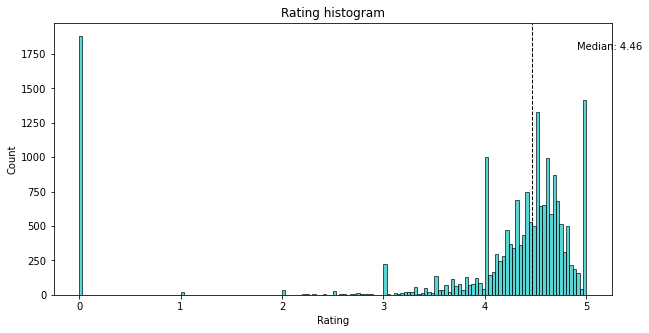

In [1017]:
##Rating distribution
plt.figure(figsize=(10,5))
np.random.seed(6789)
x = Recipe['rating']
result = plt.hist(x, bins=150, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(x.median()))
plt.title('Rating histogram')
plt.xlabel('Rating')
plt.ylabel('Count');

Insight: Most of recipe were not rated. For the rated recipe, the distribution seems negativley skwewd & most of the rated recipe has rating of 5.

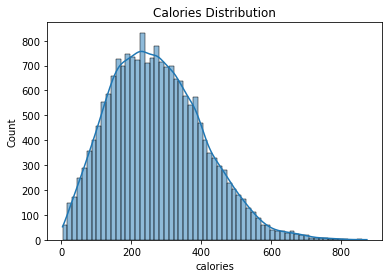

In [1018]:
##Calories/protein/carb/fat distribution
sns.histplot(Recipe.calories, kde=True)
plt.title('Calories Distribution');

Inight: The calories seems normally distributed

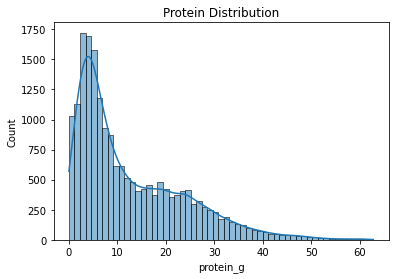

In [1019]:
sns.histplot(Recipe.protein_g, kde=True)
plt.title('Protein Distribution');

Inight: The protein seems positively skewed.

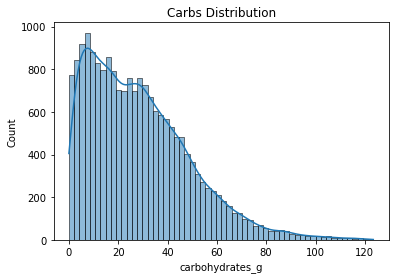

In [1020]:
sns.histplot(Recipe.carbohydrates_g, kde=True)
plt.title('Carbs Distribution');

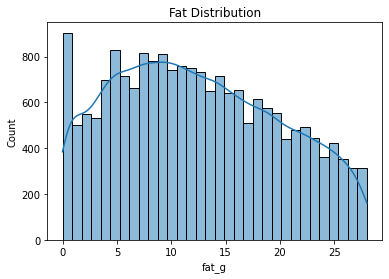

In [1021]:
sns.histplot(Recipe.fat_g, kde=True)
plt.title('Fat Distribution');

Inight: The carbs seems positively skewed.

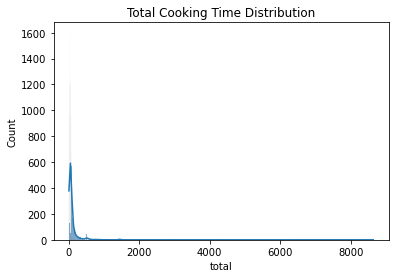

In [1022]:
##Total time distribution
sns.histplot(Recipe.total, kde=True)
plt.title('Total Cooking Time Distribution');

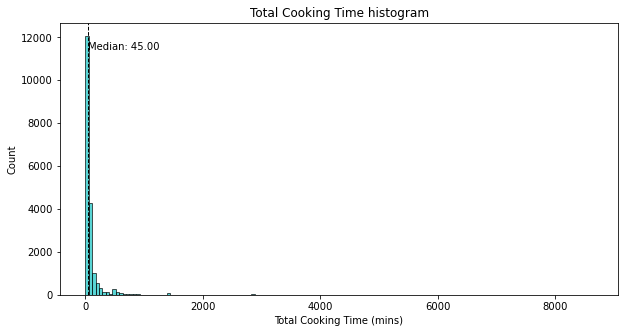

In [1023]:
##Total time distribution
plt.figure(figsize=(10,5))
np.random.seed(6789)
x = Recipe['total']
result = plt.hist(x, bins=150, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(x.median()))
plt.title('Total Cooking Time histogram')
plt.xlabel('Total Cooking Time (mins)')
plt.ylabel('Count');

Insight: Time was positively skewed

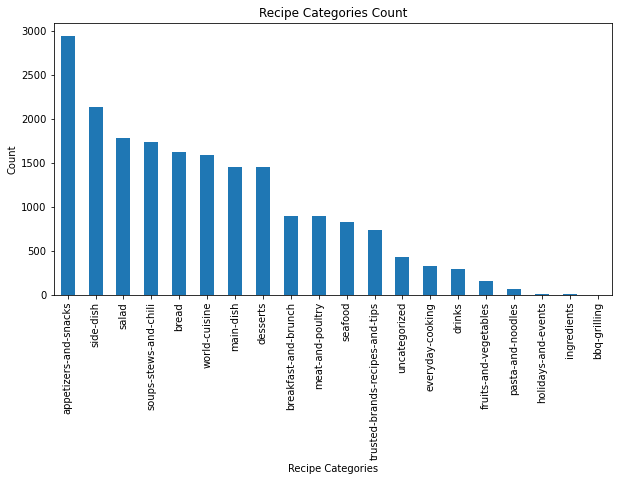

In [1024]:

##Recipe category count
category_count = Recipe.category.value_counts()
plt.figure(figsize=(10,5))
category_count.plot.bar( x = "Recipe Categories")
plt.title("Recipe Categories Count")
plt.xlabel("Recipe Categories")
plt.ylabel("Count");

Insight: Most of the recipe where appetizers & snacks

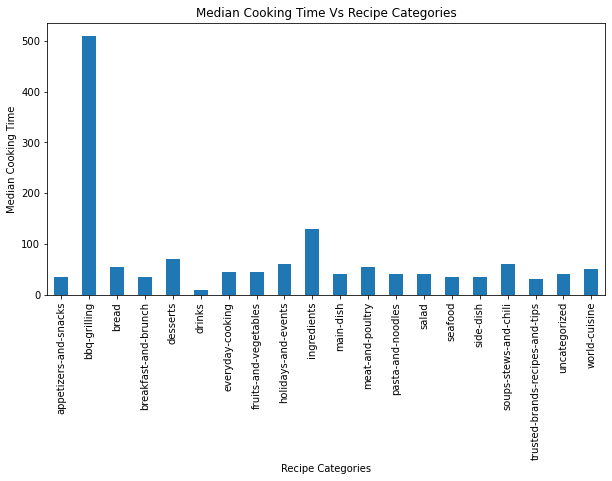

In [1025]:
##Total time vs recipe category
Med_time_category = Recipe.groupby(['category'])['total'].median()
plt.figure(figsize=(10,5))
Med_time_category.plot.bar( x = "Recipe Categories")
plt.title("Median Cooking Time Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Cooking Time");

Insight: BBQ has the heighest median time whereas drinks has the least

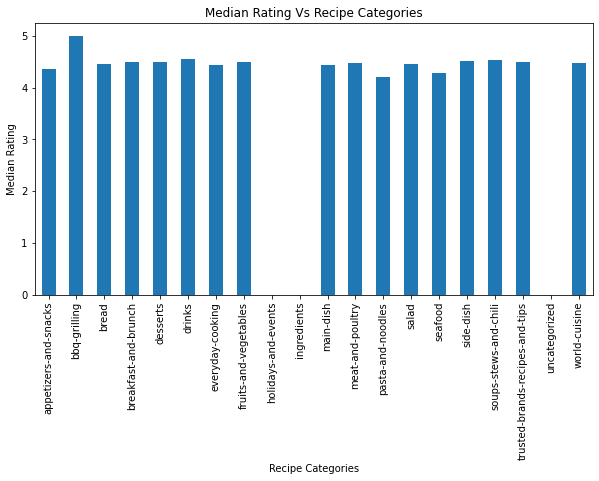

In [1026]:
##Rating (avergae/median) vs recipe category
Med_rate_category = Recipe.groupby(['category'])['rating'].median()
plt.figure(figsize=(10,5))
Med_rate_category.plot.bar( x = "Recipe Categories")
plt.title("Median Rating Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Rating");

Insight: Median rating are closely similar between categories

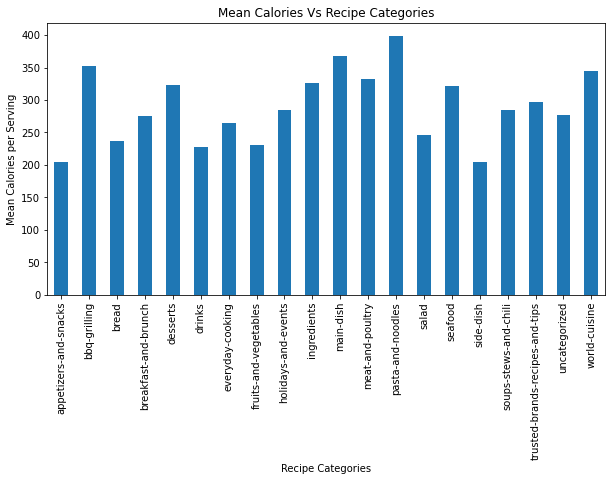

In [1027]:
##Calories (mean) vs recipe category
Mean_calories_category = Recipe.groupby(['category'])['calories'].mean()
plt.figure(figsize=(10,5))
Mean_calories_category.plot.bar( x = "Recipe Categories")
plt.title("Mean Calories Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Mean Calories per Serving");


Insight: Pasta & noodles category has the heighest calories mean, whereas appetizers & side-dishes has the lowest mean

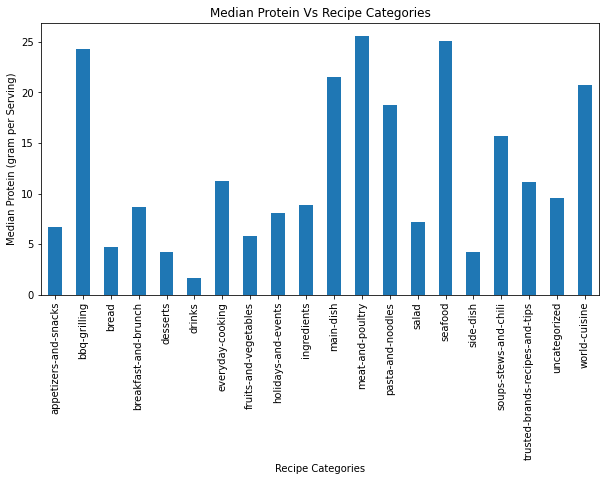

In [1028]:
##protein (median) vs recipe category
Med_pro_category = Recipe.groupby(['category'])['protein_g'].median()
plt.figure(figsize=(10,5))
Med_pro_category.plot.bar( x = "Recipe Categories")
plt.title("Median Protein Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Protein (gram per Serving)");


Insight: Meat & poultry has the heighest protein per serving median followed by seafood & BBQ

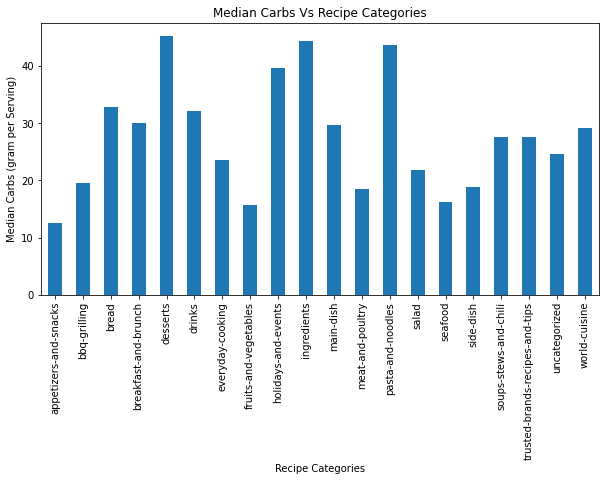

In [1029]:
##carb (median) vs recipe category
Med_carb_category = Recipe.groupby(['category'])['carbohydrates_g'].median()
plt.figure(figsize=(10,5))
Med_carb_category.plot.bar( x = "Recipe Categories")
plt.title("Median Carbs Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Carbs (gram per Serving)");

Insight: As expected, desert has the heighest carbohydrates median, whereas appetizers had the lowest

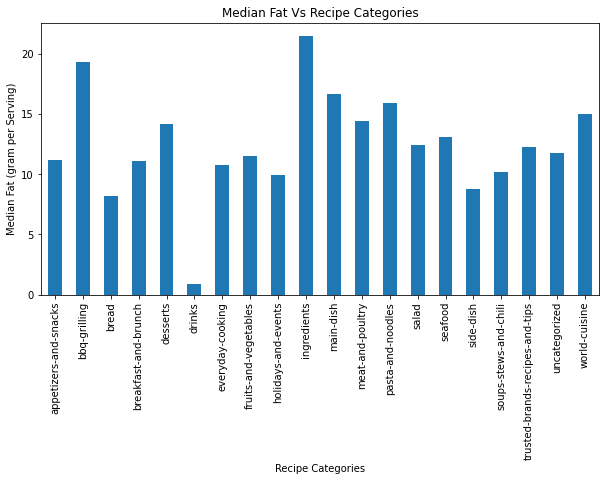

In [1030]:
##fat (median) vs recipe category
Med_fat_category = Recipe.groupby(['category'])['fat_g'].median()
plt.figure(figsize=(10,5))
Med_fat_category.plot.bar( x = "Recipe Categories")
plt.title("Median Fat Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Fat (gram per Serving)");


Insight: Ingredients category has the heighest fat median, whereas drinks has the lowest